d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loss is [4.5754993e+01 3.1103373e-02 4.5786098e+01]
loss is [0.00279173 0.00208063 0.00487237]
loss is [1.4916276e-04 1.0192185e-07 1.4926468e-04]
loss is [8.1793260e-05 1.2280516e-07 8.1916063e-05]
loss is [6.0606297e-05 4.7209014e-08 6.0653507e-05]
loss is [4.8784364e-05 1.8618179e-08 4.8802984e-05]
loss is [3.9516210e-05 1.0055083e-08 3.9526265e-05]
loss is [3.1692161e-05 6.5881838e-09 3.1698750e-05]
loss is [2.5157968e-05 4.6211586e-09 2.5162590e-05]
loss is [1.9823528e-05 3.2581564e-09 1.9826786e-05]


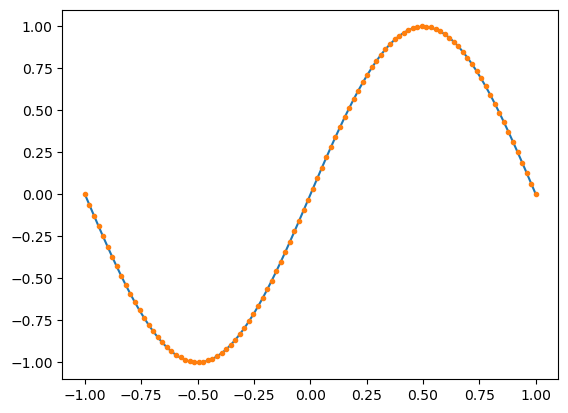

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

## define a pde
pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num
pde_input = D1Field([-1,1]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    du2dx2 = grad(dudx, x_in)[0]
    loss = -du2dx2 - (torch.pi ** 2) * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

## define a bc
bc_epoch_size = 2
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num
bc_input = np.array([[-1],[1]])
bc_output = np.zeros([bc_epoch_size ,1])
bc_batch_size = bc_epoch_size

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [1, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

epoch_num = 1000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

x_cpu = np.linspace(-1,1,100).reshape(100,1)
y_cpu = solver.model_eval(x_cpu)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')